In [103]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA

In [104]:
df_data = pd.read_csv('Data/cleaned_hotel_reviews.csv')
df_data.head()

,Review,Rating,label,clean_punc,lemmatized_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice rooms not 4 experience hotel monaco seatt...,nice room not 4 experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game awesom...,great stay great stay go seahawk game awesome ...


In [105]:
negative_reviews = df_data[df_data['label'] == 'negative']['lemmatized_review']
positive_reviews = df_data[df_data['label'] == 'positive']['lemmatized_review']
neutral_reviews = df_data[df_data['label'] == 'neutral']['lemmatized_review']


all_reviews = df_data['lemmatized_review']

vectorizer = TfidfVectorizer()
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

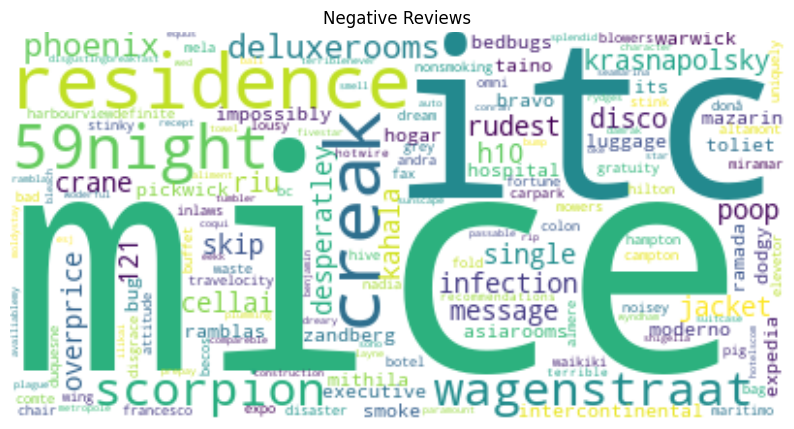

In [106]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


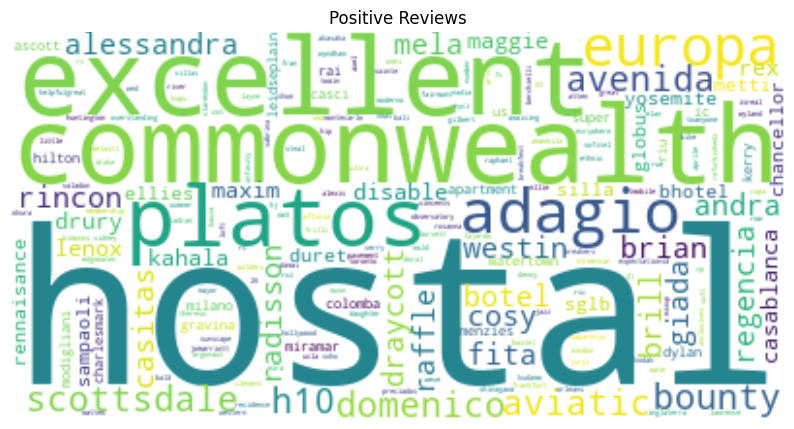

In [107]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


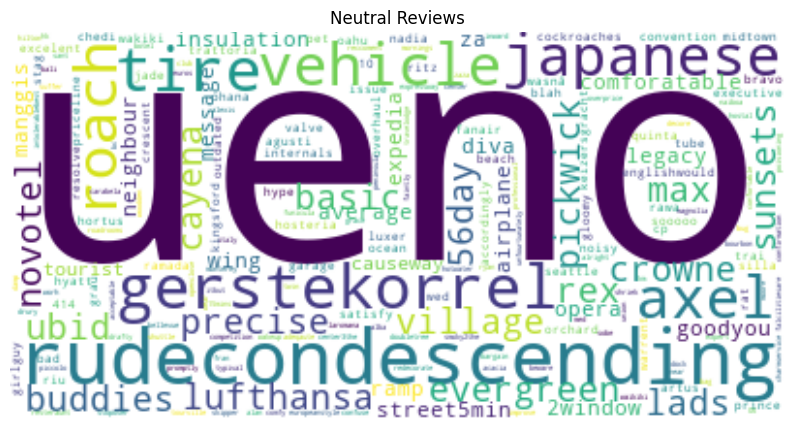

In [108]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

In [109]:
label = ['positive', 'negative', 'neutral']

def encode_label(label):
    if label == 'positive':
        return 0
    elif label == 'negative':
        return 1
    else:
        return 2

In [110]:
df_data['label'] = df_data['label'].apply(encode_label)
df_data.head()

,Review,Rating,label,clean_punc,lemmatized_review
0,nice hotel expensive parking got good deal sta...,4,0,nice hotel expensive parking got good deal sta...,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,2,1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,2,nice rooms not 4 experience hotel monaco seatt...,nice room not 4 experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,0,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,0,great stay great stay went seahawk game awesom...,great stay great stay go seahawk game awesome ...


In [111]:
x_train, x_test, y_train, y_test = train_test_split(df_data['lemmatized_review'], df_data['label'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((16392,), (4099,), (16392,), (4099,))

In [112]:
EMBEDDING_DIM = 15
MAXLEN = 32
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 20000
NUM_LABELS = 3

In [125]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [126]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 32, 15)            300000    
                                                                 
 flatten_7 (Flatten)         (None, 480)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                30784     
                                                                 


 dense_15 (Dense)            (None, 3)                 195       
                                                                 
Total params: 330,979
Trainable params: 330,979
Non-trainable params: 0
_________________________________________________________________


In [127]:
history = model.fit(x_train_pad, y_train, epochs=5, validation_data=(x_test_pad, y_test))

Epoch 1/5


513/513 [==============================] - 3s 5ms/step - loss: 0.5352 - accuracy: 0.7982 - val_loss: 0.4141 - val_accuracy: 0.8373
Epoch 2/5
513/513 [==============================] - 2s 4ms/step - loss: 0.3101 - accuracy: 0.8809 - val_loss: 0.4226 - val_accuracy: 0.8448
Epoch 3/5
513/513 [==============================] - 2s 4ms/step - loss: 0.1322 - accuracy: 0.9564 - val_loss: 0.5655 - val_accuracy: 0.8224
Epoch 4/5
513/513 [==============================] - 2s 4ms/step - loss: 0.0284 - accuracy: 0.9943 - val_loss: 0.7023 - val_accuracy: 0.8253
Epoch 5/5
513/513 [==============================] - 2s 4ms/step - loss: 0.0049 - accuracy: 0.9998 - val_loss: 0.7654 - val_accuracy: 0.8226


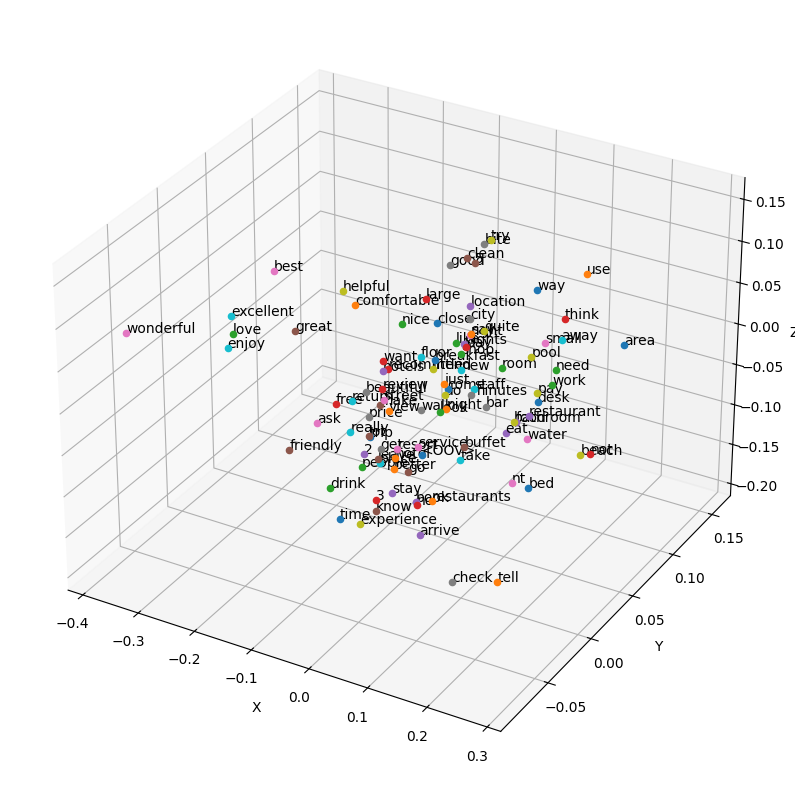

In [128]:
embeddings = model.layers[0].get_weights()[0]
pca = PCA(n_components=3, random_state=42)
embeddings_3d = pca.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
word_index = tokenizer.word_index
n_words = min(100, len(word_index))

for word, index in list(word_index.items())[:n_words]:
    x, y, z = embeddings_3d[index]
    ax.scatter(x, y, z)
    ax.text(x, y, z, word)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

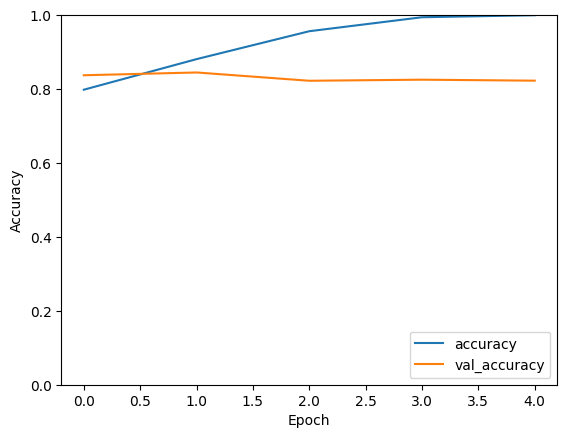

In [129]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [130]:
model.save('model.h5')